In [1]:
import pandas as pd

base = 'C:/data/apparel' # 이미지 폴더와 csv가 모두 있는 데이터 주소
# DATA_PATH = base+'/clothes_dataset'
train_df = pd.read_csv(base + '/train.csv')
val_df = pd.read_csv(base + '/val.csv')
test_df = pd.read_csv(base + '/test.csv')

train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 제너레이터를 정의합니다.
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 합니다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망 (레이블이 11개)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [4]:
class_col = train_df.columns[2:]
batch_size = 32

# 훈련자료: w,b 갱신
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42
)

# 훈련된 w,b 검증
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

Found 5578 validated image filenames.
Found 2391 validated image filenames.


Index(['black', 'shoes'], dtype='object')


c:\Users\user\miniconda3\envs\gpu\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


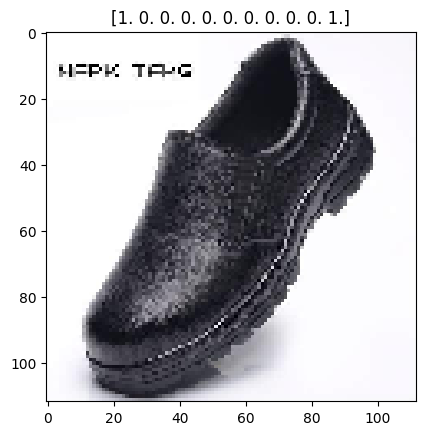

In [5]:
# 참고,  flower 자료와 같음.
import numpy as np
len(train_generator[0])   # 5578개를 32개씩 묶으면 175개의 묶음이 생기고 그중 첫번째 묶음자료는 img 32하고 레이블 32개로 구성됨
train_generator[0][1] # 레이블 

import matplotlib.pyplot as plt
plt.imshow(train_generator[0][0][0])
plt.title(train_generator[0][1][0])

for x in np.where(train_generator[0][1][0]==1):
    print(class_col[x])

In [6]:
for x in np.where(train_generator[0][1][0]): # (train_generator[0][1][0] == 1)

IndentationError: expected an indented block (3155015554.py, line 1)

In [ ]:
model.fit(train_generator,
         steps_per_epoch=get_steps(len(train_df), batch_size),
         validation_data = val_generator,
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 1)

175/175 [==============================] - 11s 64ms/step - loss: 0.2391 - acc: 0.5059 - val_loss: 0.2733 - val_acc: 0.4103


In [ ]:
# 5. 모델 평가하기
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base,
    x_col='image',
    y_col=class_col,
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

loss_and_metrics = model.evaluate(test_generator,
                                  steps=get_steps(len(test_df), batch_size))
print('loss_and_metrics : ' + str(loss_and_metrics)) # 리스트라서 스트링으로 만들기

Found 3416 validated image filenames.
107/107 [==============================] - 4s 34ms/step - loss: 0.2696 - acc: 0.3967
loss_and_metrics : [0.269560843706131, 0.39666277170181274]


In [ ]:
# 6. 모델 저장하기
import os
save_path = os.path.join('model', 'img_generator_model.h5')
model.save(save_path)

In [ ]:
### 예측 추가
preds = model.predict(test_generator)

107/107 [==============================] - 4s 35ms/step


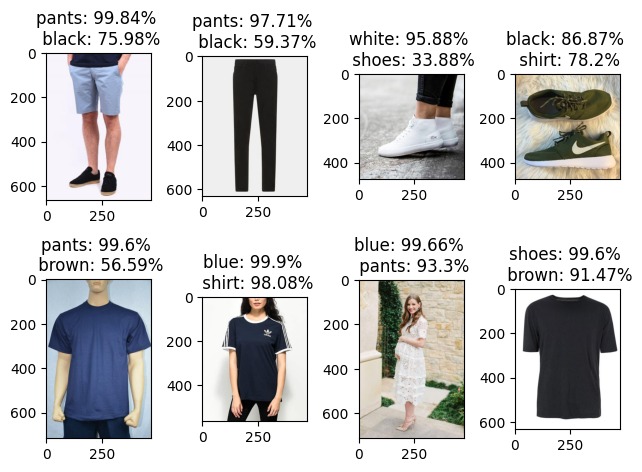

In [ ]:
# 8개만 예측해보도록 하겠습니다.
do_preds = preds[:8]

import cv2
import matplotlib.pyplot as plt
for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i + 1)
    prob = zip(class_col, list(pred))
    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]

    image = cv2.imread(base+test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')

plt.tight_layout()

In [ ]:
test_df['image'].str.split('\\')[0] # 요소들의 문자열을 스플릿
str(test_df['image']).split('\\') # 시리즈의 요소들을 기준으로 스플릿
test_df['image'].str.split('\\')[0] # 요소들의 문자열을 스플릿

['./clothes_dataset',
 'blue_shorts',
 '1ec871cdfe41ff2093fff53f11f315f2027396cc.jpg']

In [60]:
prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]
prob

[('shoes', 0.99596834), ('brown', 0.9146847)]